<a href="https://colab.research.google.com/github/IKnigencev/Deep-Learning-example/blob/main/BraimMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Проект по распознованию опухоли мозга**
# Dataset взят с Kaggle 
https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

## Загрузка датасета

**Подключение к google disk**

In [ ]:
from google.colab import drive  # Импорт библиотеки из колаба для подключения к вашему google disk 
drive.mount('/content/drive')   # Подкючения google disk к локальной директориии ноутбука 

Mounted at /content/drive


**Загрузка kaggle.json с компьютера, скачать его нужно в своем профиле на kaggle**

In [ ]:
from google.colab import files  # Импорт бибилотеки для загрузки файлов с компьютера
files.upload()                  # Функиця загрузки файлов с компьютера, ниже появится кнопка выбора файла

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ivanknihencev","key":"3dad09d80e2f8395768873599ff2dbc6"}'}

**Подключение к директории kaggle**

In [ ]:
 ! pip install -q kaggle 
 !mkdir ~/.kaggle
 !cp kaggle.json ~/.kaggle/
 !chmod 600 ~/.kaggle/kaggle.json

**Загрузка данных из kaggle, ссылку на загрузку данных можно найти на странице датасета**

In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


**Данные скачиваются в zip файле, ниже происоходит распаковка данных в папку train**

In [ ]:
! unzip brain-mri-images-for-brain-tumor-detection.zip -d train

Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: train/brain_tumor_dataset/no/1 no.jpeg  
  inflating: train/brain_tumor_dataset/no/10 no.jpg  
  inflating: train/brain_tumor_dataset/no/11 no.jpg  
  inflating: train/brain_tumor_dataset/no/12 no.jpg  
  inflating: train/brain_tumor_dataset/no/13 no.jpg  
  inflating: train/brain_tumor_dataset/no/14 no.jpg  
  inflating: train/brain_tumor_dataset/no/15 no.jpg  
  inflating: train/brain_tumor_dataset/no/17 no.jpg  
  inflating: train/brain_tumor_dataset/no/18 no.jpg  
  inflating: train/brain_tumor_dataset/no/19 no.jpg  
  inflating: train/brain_tumor_dataset/no/2 no.jpeg  
  inflating: train/brain_tumor_dataset/no/20 no.jpg  
  inflating: train/brain_tumor_dataset/no/21 no.jpg  
  inflating: train/brain_tumor_dataset/no/22 no.jpg  
  inflating: train/brain_tumor_dataset/no/23 no.jpg  
  inflating: train/brain_tumor_dataset/no/24 no.jpg  
  inflating: train/brain_tumor_dataset/no/25 no.jpg  
  inflating: train/brain_

## Обработка датасета

In [ ]:
# Удаление лишней папки, которая была добавлена при скачивание датасета

!rm -rf /content/train/brain_tumor_dataset

### Подключение необходимых библиотек

In [ ]:
import cv2

import os

import numpy as np 

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

from tensorflow.keras.optimizers import Adam     

from tensorflow.keras import utils

import tensorflow as tf
import keras
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from PIL import Image, ImageColor
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt  

%matplotlib inline 

*Так как в datasete довольно малое количество фотографий, хорощим решением будет применить агументацию*


In [ ]:
# Установка переменных, которые будут использоваться в ходе обучения

IMG_WIDTH           = 64                  
IMG_HEIGHT          = 64                 
IMG_CHANNELS        = 3  

TEST_SPLIT          = 0.1                   
VAL_SPLIT           = 0.1 

ROTATION_RANGE      = 8                     
WIDTH_SHIFT_RANGE   = 0.15                  
HEIGHT_SHIFT_RANGE  = 0.15                 
ZOOM_RANGE          = 0.15                  
BRIGHTNESS_RANGE    = (0.7, 1.3)            
HORIZONTAL_FLIP     = True   

BATCH_SIZE          = 16

**Распределение данных на тренировочный и тестовый датасет**

In [ ]:
train = '/content/train'
class_list = sorted(os.listdir(train))

In [ ]:
!rm -rf '/content/test_path'

In [ ]:
os.mkdir('/content/test_path')

Test_path = '/content/test_path'

train_count = 0
test_count = 0 

for class_name in class_list:
  class_path = f'{train}/{class_name}'
  test_path = f'{Test_path}/{class_name}'
  class_files = os.listdir(class_path)
  class_file_count = len(class_files)
  os.mkdir(test_path) 
  test_file_count = int(class_file_count * TEST_SPLIT)
  test_files = class_files[-test_file_count:] 
  for f in test_files:                                   
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}') 
  train_count += class_file_count                        
  test_count += test_file_count     

  print(f'Размер класса {class_name}: {class_file_count} фото, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса no: 98 фото, для теста выделено файлов: 9
Размер класса yes: 155 фото, для теста выделено файлов: 15
Общий размер базы: 253, выделено для обучения: 229, для теста: 24


### **Агументация изображений**

In [ ]:
# Производится в случайном порядке изменение фотографий на тренировочных и тестовых данных
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )


test_datagen = ImageDataGenerator(
                   rescale=1. / 255.
                )

### Разделение данных 

In [ ]:
# Распределение данных на тренировочные, валидационные и тестовые
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    Test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 207 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


## Обучение модели

In [ ]:
# Сборка модели 
model = Sequential()

model.add(Conv2D(16, (6,6), padding='same', activation='relu', input_shape=(IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))) # input_shape не менять !
model.add(BatchNormalization())

model.add(Conv2D(16, (2,2), padding='same', activation='relu'))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(250, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        1744      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        1040      
                                                                 
 dropout (Dropout)           (None, 64, 64, 16)        0         
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 250)               16384250  
                                                        

In [ ]:
!rm -rf check_point

In [ ]:
# Обучение модели с сохранением лучшей эпохи обучения, где был достигнут наибольший результат на валидационных данных

os.mkdir('/content/check_point')

path_checkpoint = '/content/check_point'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_checkpoint,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(train_generator,
                    epochs=60,
                    validation_data=validation_generator,
                    verbose=1,
                    callbacks=[model_checkpoint_callback])

model.load_weights(path_checkpoint)

Epoch 1/60
13/13 [==============================] - 5s 388ms/step - loss: 0.4384 - accuracy: 0.8068 - val_loss: 0.4473 - val_accuracy: 0.7273
Epoch 2/60
13/13 [==============================] - 5s 391ms/step - loss: 0.3898 - accuracy: 0.8116 - val_loss: 0.3779 - val_accuracy: 0.8182
Epoch 3/60
13/13 [==============================] - 5s 382ms/step - loss: 0.3882 - accuracy: 0.8116 - val_loss: 0.4317 - val_accuracy: 0.8636
Epoch 4/60
13/13 [==============================] - 5s 340ms/step - loss: 0.3871 - accuracy: 0.8116 - val_loss: 0.5203 - val_accuracy: 0.7273
Epoch 5/60
13/13 [==============================] - 4s 339ms/step - loss: 0.3584 - accuracy: 0.8309 - val_loss: 0.3727 - val_accuracy: 0.8636
Epoch 6/60
13/13 [==============================] - 4s 334ms/step - loss: 0.3448 - accuracy: 0.8551 - val_loss: 0.5262 - val_accuracy: 0.7727
Epoch 7/60
13/13 [==============================] - 4s 337ms/step - loss: 0.4030 - accuracy: 0.8116 - val_loss: 0.6768 - val_accuracy: 0.8182
Epoch 

In [ ]:
# Определение процента распознования на тестовых данных 
scores = model.evaluate(test_generator)

1/1 [==============================] - 0s 203ms/step - loss: 0.3339 - accuracy: 0.8750


In [ ]:
print('Процент верных ответов на тестовых данных:', round(scores[1],2) * 100, '%')

Процент верных ответов на тестовых данных: 88.0 %


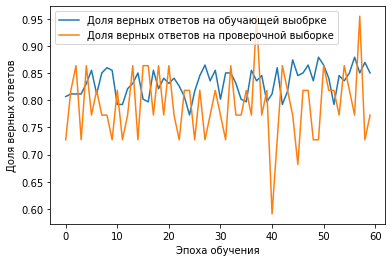

In [ ]:
# Визуализация процесса обучения
plt.plot(history.history['accuracy'], 
                  label='Доля верных ответов на обучающей выобрке')
plt.plot(history.history['val_accuracy'], 
                  label='Доля верных ответов на проверочной выборке')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

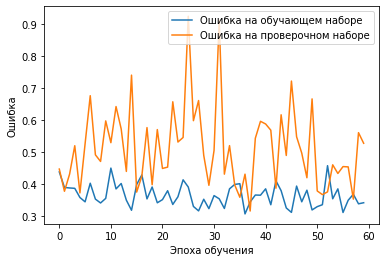

In [ ]:
# Визуализация ошибки на данных
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [ ]:
# Сохранение модели
model.save('drive/MyDrive/model/Project/models.h5')

## Проверка результатов модели с 91%

Обучение с использованием keras tuner происходило не в этом ноутбуке, модель была загружена на гугл диск с результатом 91%.  Здесть проверятеся процент распознования на тестовых данных.

In [ ]:
from tensorflow.keras.models import load_model

model_1 = load_model('drive/MyDrive/model/Project/models_M.h5')

scores = model_1.evaluate(test_generator)

1/1 [==============================] - 0s 339ms/step - loss: 0.3754 - accuracy: 0.8750


## Обучение на готовой архитектуре VGG16

In [ ]:
# Основные переменные
data_dir = '/content/train/' 
batch_size= 16
image_size= (64, 64)

initial_epochs = 30
base_learning_rate = 0.00001

In [ ]:
# Распределение данных на тренировочные и валидационные 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,    # Устанавливаем разделение на обучающую и проверочную выборки
  subset="training",       # Эта выборка обучающая
  seed=123,                # закрепляем рандом для сравнения сетей
  image_size= image_size,
  batch_size= batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",     # Эта выборка проверочная
  seed=123,
  image_size= image_size,
  batch_size= batch_size)

Found 253 files belonging to 2 classes.
Using 203 files for training.
Found 253 files belonging to 2 classes.
Using 50 files for validation.


In [ ]:
# Определяем имена классов
class_names = train_ds.class_names 
print(class_names)

['no', 'yes']


In [ ]:
# Предварительная подгрузка датасета для ускорения и стабилизации
AUTOTUNE = tf.data.AUTOTUNE    

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE) 
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomZoom((-0.05,0.05)), # произвольное увеличение и уменьшение на 10%
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.15)]) 

In [ ]:
import gc
# Слой подготовки данных (у каждой модели свой)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
gc.collect()

# Создание модели
image_shape = image_size + (3,)
base_model = tf.keras.applications.vgg16.VGG16(input_shape=image_shape,
                         include_top=False,
                         weights='imagenet')

# base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # Глобал пулинг
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax') # По количеству классов

# собираем полную модель 
inputs = tf.keras.Input(shape=(image_shape))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Сборка модели
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# Функция ранней остановки обучения, когда ошибка на валидационных данных перестанет уменьшатся 
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# Обучение модели
hVGG16 = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                   callbacks=[early_stop])

Epoch 1/30
13/13 [==============================] - 44s 3s/step - loss: 2.4443 - accuracy: 0.5567 - val_loss: 0.4798 - val_accuracy: 0.7800
Epoch 2/30
13/13 [==============================] - 41s 3s/step - loss: 0.4694 - accuracy: 0.7833 - val_loss: 0.4221 - val_accuracy: 0.8200
Epoch 3/30
13/13 [==============================] - 44s 3s/step - loss: 0.3187 - accuracy: 0.8374 - val_loss: 0.3672 - val_accuracy: 0.8000
Epoch 4/30
13/13 [==============================] - 42s 3s/step - loss: 0.2772 - accuracy: 0.8768 - val_loss: 0.2952 - val_accuracy: 0.9000
Epoch 5/30
13/13 [==============================] - 56s 4s/step - loss: 0.2030 - accuracy: 0.9458 - val_loss: 0.2687 - val_accuracy: 0.9000
Epoch 6/30
13/13 [==============================] - 48s 4s/step - loss: 0.1757 - accuracy: 0.9310 - val_loss: 0.2439 - val_accuracy: 0.8800
Epoch 7/30
13/13 [==============================] - 41s 3s/step - loss: 0.1068 - accuracy: 0.9655 - val_loss: 0.2649 - val_accuracy: 0.9200
Epoch 8/30
13/13 [==

In [ ]:
# Проверка на тестовых данных
scores = hVGG16.evelute(t)

# Создание скрипта для интеграции в систему 


In [ ]:
# Подлкючение к гугл диску для загрузки модели

from google.colab import drive   
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Скрипт для обрабокти и вывода результата нейронной сети

from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

def prediction(img_path='train/no/1 no.jpeg', model_path='models_MRI.h5'):

  name_pred = ['no', 'yes']

  img_width, img_height = 64, 64

  model = load_model(model_path)
  img = Image.open(img_path).resize((img_width, img_height))
  image = np.array(img, 'float64') / 255.

  image = np.expand_dims(image, axis=0)
  predd = model.predict(image)
  pred = np.argmax(predd)
  print(predd)
  print(f'Вероятоность {round(predd[0][1], 2) * 100}%')
  print(name_pred[pred])


In [ ]:
prediction(img_path='drive/MyDrive/8neyro.jpg', model_path='drive/MyDrive/model/Project/models_MRI_83%.h5')

[[0.3189975 0.6810025]]
Вероятоность 68.00000071525574%
yes
